# Introduction to Shapley Values

In this notebook, we'll introduce Shapley Values, and their application to machine learning. The focus here will be to take the theoretical definitions, and convert them into a tangible example worked in Python code.

## Motivation

Machine learning and AI have seen increasing adoption in industry over the past decade. This technology is being used to automate processes within a wide variety of industries, ranging from finance, to retail, manufacturing, and health care to name a few. Much of this increasing adoption is driven by: 
1. The increasing availability of data
2. The inhanced computational power that is available

Both points above allow the creation of increasingly more complex machine learning models. These models allow for inhanced prediction quality and accuracy, however they are notoriously difficule to understand! How does the model generate the predictions that it does, in terms that (non-technicial) stakeholders can understand?

This is where **Shapley Values** come in. These quantify what input predictor features contribute to each individual model output. These were introduced by Lloyd Shapley in 1953:

Lloyd Shapley. A Value for N-Person Games. *Contributions to the Theory of Games*, pages 307–317, 1953.

## Classic Definition

The Shapley Value $\phi_i$, for one feature $i$ out of all available features $F$, is defined mathematically as:

$$\phi_i = \sum_{S \subseteq F \backslash \{i\}} \frac{|S|!(|F|-|S|-1)!}{|F|!} [v(S\cup\{i\})-v(S)]$$

where:
* $S$ is a subset of the total possible features $F$, minus the feature we're focusing on $i$
* $v$ is a value function, based off of the model output for a single sample of interest $x$ 

The value function $v$ is typically expressed in the following form:

$$v(S) = y_p(x_S) - \hat{y}(X_S)$$

where:
* $y_p(x_S)$ is the model output for a single sample $x_S$ that includes $S$ features
* $\hat{y}(X_S)$ is the expected model output over all available samples $X_S$ with $S$ features. Note $x_S \in X_S$  

The definition above was originally developed within the context of Game Theory. However, here I've altered the terminology to be representative of the machine learning scenario we are interested in.

## Worked Python Example

Let's now work through an example, to make these concepts tangible:

In [2]:
# imports
import math
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [3]:
# create a simple regression dataset
X, y = make_regression(n_samples=10, n_features=3, noise=1, random_state=42)

In [4]:
X

array([[ 0.76743473,  1.57921282, -0.46947439],
       [-0.23415337,  1.52302986, -0.23413696],
       [ 0.11092259, -0.54438272, -1.15099358],
       [-0.60063869,  0.37569802, -0.29169375],
       [-1.91328024,  0.24196227, -1.72491783],
       [-1.01283112, -0.56228753,  0.31424733],
       [-0.1382643 ,  0.49671415,  0.64768854],
       [-0.46341769,  0.54256004, -0.46572975],
       [-1.4123037 , -0.90802408,  1.46564877],
       [ 0.0675282 , -0.2257763 , -1.42474819]])

In [5]:
y

array([ 135.87495442,   91.04151968,  -46.19406261,   -3.4087805 ,
        -89.97336122,  -78.12657288,   35.27171292,   11.43196996,
       -103.62807383,  -28.66982502])

In [6]:
# scale the input predictor features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
# declare a model instance
model = LinearRegression()

In [9]:
def val(S: list, x_j: np.array, X: np.array, y: np.array, model: object) -> float:
    """
    Value function for use in the calculation of the Shapley value
    """
    if S:
        model.fit(X[:,S],y)
        return model.predict(x_j.reshape(1,-1)[:,S]) - np.mean(model.predict(X[:,S]))
    else:
        return 0.0

In [10]:
def subsets(features: list) -> list:
    """
    Function to return all possible subsets for the input list of features
    """
    subset_combinations = list()
    for n in range(len(features) + 1):
        subset_combinations += list(combinations (features, n))
    return subset_combinations

In [11]:
def shapley(x_j: np.array, i: int, X: np.array, y: np.array, model: object) -> float:
    """
    Ultimate function to compute the Shapley value for a sample of interest x_j, and feature i
    """
    # determine feature names, and count how many there are
    F = [f for f in range(X.shape[1])]
    F_count = len(F)
    # remove the feature of interest i from F
    F.remove(i)
    # loop over each subset in S
    phi = 0
    for S in subsets(F):
        # compute weight
        S_count = len(S)
        w = math.factorial(S_count)*math.factorial(F_count - S_count - 1)/math.factorial(F_count)
        # compute difference in value function
        diff_value = val(list(S + (i,)), x_j, X, y, model) - val(list(S), x_j, X, y, model)
        # add results
        phi += w*diff_value
    return phi[0]

We can manually work through the calculations for a single sample in detail:

In [12]:
# obtain a sample
x_1 = X[1,:]

In [13]:
# shapley value for feature 0
s_0 = shapley(x_1, 0, X, y, model)
s_0

3.008446860031037

In [14]:
# shapley value for feature 1
s_1 = shapley(x_1, 1, X, y, model)
s_1

93.13370588107563

In [15]:
# shapley value for feature 2
s_2 = shapley(x_1, 2, X, y, model)
s_2

2.092127584279774

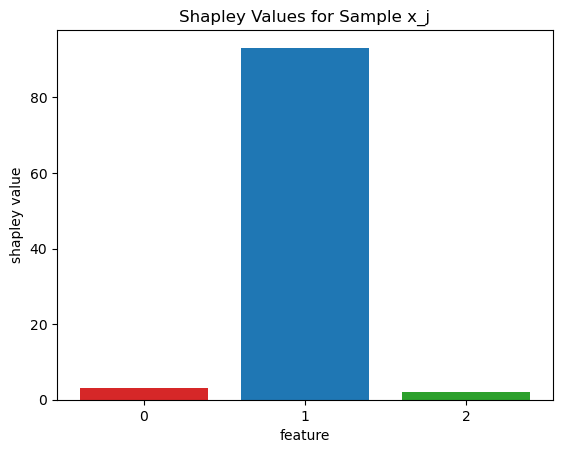

In [16]:
# plot the feature shapley values for x_j
fig, ax = plt.subplots()

features = ['0', '1', '2']
values = [s_0, s_1, s_2]
bar_colors = ['tab:red', 'tab:blue', 'tab:green']

ax.bar(features, values, color=bar_colors)
ax.set_xlabel('feature')
ax.set_ylabel('shapley value')
ax.set_title('Shapley Values for Sample x_j')

plt.show()

Sanity check, do the Shapley Values $\phi_i$ sum to the difference between $y_p(x) - \hat{y}(X)$?

In [17]:
shapley(x_1, 0, X, y, model) + shapley(x_1, 1, X, y, model) + shapley(x_1, 2, X, y, model)

98.23428032538645

In [18]:
model.fit(X,y)
model.predict(x_1.reshape(1,-1)) - np.mean(model.predict(X))

array([98.23428033])

What are the expected Shapley Values for all samples in $X$? And how do these compare with our model parameters?

In [19]:
results = {0:[],1:[],2:[]}
for j in range(X.shape[0]):
    x_j = X[j,:]
    for i in range(X.shape[1]):
        results[i].append(shapley(x_j, i, X, y, model))

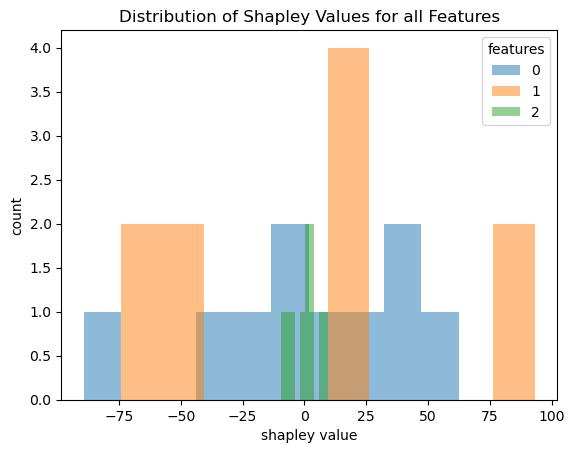

In [20]:
plt.hist(results[0], alpha=0.5, bins=10, label='0')
plt.hist(results[1], alpha=0.5, bins=10, label='1')
plt.hist(results[2], alpha=0.5, bins=10, label='2')
plt.xlabel('shapley value')
plt.ylabel('count')
plt.title('Distribution of Shapley Values for all Features')
plt.legend(title='features')
plt.show()

In [21]:
model.fit(X,y)
model.coef_

array([33.17695477, 54.12190107, 11.73925815])

## Concluding Remarks

The above results demonstrate that our implementation works, and the results that we get are consistent with our inituition for this linear model. In other words, features with larger model coefficients tend to be allocated larger absolute shapley values. Note that the calculation of the Shapley Value is completely model agnostic. 

### So What's Wrong with our Approach?

There are a couple of reasons why using the "classic" Shapley Value definition isn't suitable for machine learning:
1. The number of subsets $S$ we need to iterate over becomes exponentially larger as $F$ increases
2. Retraining our model for each value function call isn't very sensible: many models will not function on just a subset of features, and the training times can be quite long!

Due to these reasons, in practice approximate sampling methods are used for machine learning problems. In a subsequent video, I'll cover how this works.  